# 4-Evaluator
This notebook uses to compare Gemini-1.5-flash and GPT-4o-mini with ResNET and VGG. We will use Accuracy, Precision, Recall and F1-score to evaluate the results

## Post processing
We input single image to VLM with returning of JSON format results, however, the way that ThaiRAP classify the attributes is they use 1 to 4 image(s) for a 100-m road segment, meaning there is/are 1 to 4 image(s) sharing all the same 52 attributes (using 'index' to match). Therefore, we need to choose the highest risk class of each attribute (iRAP 2024a,b).

Note: there are 2037 images to represent 519 segments. We will match images' results by image_id on segement then choose the highest risk code to represent the segment.

We evalute V-RoAst with 492 images ('image_id') as VGG and ResNet in which there are 337 segments ('index') in total

# ThaiRAP Result processor (Post processing)

## Match the result with ground truth
Note: there are 2037 images to represent 519 segments. We will match images' results by image_id on segement then choose the highest risk code to represent the segment

### Convert text results to numbers
This dealed with responses that might not return 100% correct (e.g. returning _none_ instead of no present)

## ThaiRAP-gpt-4o-mini

In [23]:
ThaiRAP_gpt_4o_mini = './result/gpt4o-mini_thairap.csv'

In [24]:
import pandas as pd
import numpy as np
import re
from fuzzywuzzy import process
import json

# Choose either 'ThaiRAP_gpt_4o_mini' or 'ThaiRAP_gemini_1_5_flash' as the result_from_vlm_path
#
# gemini-1.5-flash
# result_from_vlm_path = ThaiRAP_gemini_1_5_flash
#
# gpt-4o-mini
result_from_vlm_path = ThaiRAP_gpt_4o_mini

# Load the JSON file containing the prompts
json_file_path = './text/prompts.json'
with open(json_file_path, 'r') as file:
    prompts = json.load(file)

def normalize_text(text):
    """
    Normalize text by stripping leading/trailing spaces, standardizing units, 
    and converting to lowercase.
    """
    if not isinstance(text, str):
        return text
    text = text.strip().lower()
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text

def fuzzy_map(value, mapping):
    """
    Fuzzy map a value to the closest key in the mapping dictionary.
    """
    if value in mapping:
        return mapping[value]
    
    # Find the closest match with a minimum threshold for similarity
    match, score = process.extractOne(value, mapping.keys())
    if score >= 80:  # Set a threshold for matching (80 is a common threshold)
        return mapping[match]
    else:
        return np.nan  # or any default value, e.g., -1 or "unmatched"

# Define groups for similar or equivalent phrases
grouped_mappings = {
    "_none_": ["_none_", "no facility", "not applicable", "not present", 
             "not applicable (no school at the location)", "no road works", "no object"]
    # Add other groupings as needed
}

# Function to replace grouped values based on grouped_mappings
def replace_grouped_values(text, grouped_mappings):
    text = normalize_text(text)
    for key, synonyms in grouped_mappings.items():
        if text in [normalize_text(synonym) for synonym in synonyms]:
            return key
    return text  # Return original text if no match is found

# Load the CSV file and apply grouped mappings
result_from_vlm_path = result_from_vlm_path
df = pd.read_csv(result_from_vlm_path, keep_default_na=False)

df_new = df.copy()  # Create a copy of the DataFrame
# clean the image_id column by getting only numbers/ get only number before space


# Correct 'Differential speed limits', Intersection channelisation, Intersecting road volume, Intersection quality, Quality of curve
# If Speed limit, Motorcycle speed limit and Truck speed limit are over 20km/h, set 'Differential speed limits' to 'Present'
speed_limit_columns = ['Speed limit', 'Motorcycle speed limit', 'Truck speed limit']
df_new['Differential speed limits'] = df.apply(
    lambda x: 'Present' if all(pd.to_numeric(x[col], errors='coerce') > 20 for col in speed_limit_columns) else x['Differential speed limits'],
    axis=1
)

# change Speed limit, Motorcycle speed limit and Truck speed limit to string
df_new[speed_limit_columns] = df_new[speed_limit_columns].astype(str)

# If Intersection type is '_None_', 'Intersection channelisation' = 'Not present', 'Intersecting road volum'e = 'Not applicable', 'Intersection quality' = 'Not applicable'
df_new.loc[df_new['Intersection type'] == '_None_', ['Intersection channelisation', 'Intersecting road volume', 'Intersection quality']] = ['Not present', 'Not applicable', 'Not applicable']

# If 'Curvature' = 'Straight or gently curving', 'Quality of curve' = 'Not applicable'
df_new.loc[df_new['Curvature'] == 'Straight or gently curving', 'Quality of curve'] = 'Not applicable'


gt = pd.read_csv('./Validation.csv')

#match column 'image_id' in both dataframes and get only 'index' column from gt
# Ensure the 'image_id' column is of type string in both dataframes
df_new['image_id'] = df_new['image_id'].astype(str)
gt['image_id'] = gt['image_id'].astype(str)
df_new = df_new.merge(gt[['image_id', 'index']], on='image_id', how='left')
#df_new = pd.concat(df_new, gt[['image_id', 'index']], on='image_id', how='left')

# Apply grouped mappings to the DataFrame
for col in df_new.columns:
    df_new[col] = df_new[col].apply(lambda x: replace_grouped_values(x, grouped_mappings))

# Create a dictionary of mappings for each column (Item) with normalization and grouping applied
mappings = {}
for attribute in prompts['attributes']:
    item = attribute['Item']
    category_mapping = {}
    for category in attribute['categories']:
        # Apply grouped mappings to category names
        standardized_category = replace_grouped_values(category['Category'], grouped_mappings)
        normalized_category = normalize_text(standardized_category)
        category_mapping[normalized_category] = str(category['Cat ID'])
    mappings[item] = category_mapping

# Debugging: Store unmatched values
unmatched_values = {}

# Apply the mapping to each relevant column in the DataFrame
for item, mapping in mappings.items():
    if item in df_new.columns:
        df_new[item] = df_new[item].apply(normalize_text).apply(lambda x: fuzzy_map(x, mapping))
        # Store any unmatched values for debugging
        unmatched_values[item] = df_new[df_new[item] == -1][item]
        df_new[item] = df_new[item].fillna(-1)  # Handle unmapped values


### Get results to 519 segments (2037>519)
Coding options for each attribute are listed in order of *highest to lowest risk*. Therefore, if an attribute varies within a single coding segment, record the item that appears first in the list of options for that attribute. (IRAP Coding Manual Drive on the Left/Right Edition, page21)

In [25]:
# Normalize function to standardize text
def normalize_text(text):
    """
    Normalize text by stripping leading/trailing spaces, standardizing units, 
    and converting to lowercase.
    """
    if not isinstance(text, str):
        return str(text).strip().lower()
    return text.strip().lower()

# Create a dictionary to map item names to their category lists
item_category_map = {}
for attribute in prompts['attributes']:
    item = attribute['Item']
    categories = [normalize_text(category['Cat ID']) for category in attribute['categories']]
    item_category_map[item] = categories

# Map each 'index' to the 'image_ids' in the ground truth data
index_to_image_ids = gt.groupby('index')['image_id'].apply(list).to_dict()

# Function to select the first occurring Cat ID for each index based on the rule
def select_cat_id_for_index(index, df_new, item):
    image_ids = index_to_image_ids.get(index, [])
    categories = item_category_map.get(item, [])
    
    # Debugging prints to check values
    # print(f"Index: {index}, Item: {item}")
    # print(f"Categories: {categories}")
    
    for image_id in image_ids:
        print(f"Image ID: {image_id}")
        cat_id_values = df_new.loc[df_new['image_id'] == image_id, item].values
        if cat_id_values.size > 0:
            print(f"Cat ID Values in df_new: {cat_id_values[0]}")
        for cat in categories:
            if cat_id_values.size > 0 and normalize_text(cat_id_values[0]) == cat:
                return df_new.loc[df_new['image_id'] == image_id, item].values[0]
    return None

# Assuming df_new is your DataFrame with 'image_id' and 'index' columns
# For demonstration purposes, let's load a sample or mock df_new here
# df_new = pd.read_csv('path_to_your_df_new.csv')  # Uncomment to load your actual data

# Ensure data types are consistent
df_new['image_id'] = df_new['image_id'].astype(str)

# Debugging prints to check data types
# print(df_new.dtypes)

# Group by 'index' and select the first occurring Cat ID for each item
result_rows = []
for index, group in df_new.groupby('index'):
    selected_row = {'index': index}
    for item in df_new.columns:
        if item != 'image_id' and item != 'index':  # Skip the image_id and index columns
            selected_value = select_cat_id_for_index(index, group, item)
            selected_row[item] = selected_value
            # Debugging print statements
            if selected_value is None:
                print(f"No match found for index {index} and item {item}")
    result_rows.append(selected_row)

# Create a DataFrame from the selected rows
gpt4o_mini_thairap_segment = pd.DataFrame(result_rows)

# Save the result to a CSV file
gpt4o_mini_thairap_segment.to_csv('result/gpt4o-mini_thairap_segment.csv', index=False)



Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 3
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 2
Image ID: 1
Cat ID Values in df_new: 11
Image ID: 1
Cat ID Values in df_new: 11
Image ID: 1
Cat ID Values in df_new: 7
Image ID: 1
Cat ID Values in df_new: 2
Image ID: 1
Cat ID Values in df_new: 7
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 17
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 17
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 12
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID V

In [5]:
gpt4o_mini_thairap_segment #ThaiRAP_gpt_4o_mini

,index,Carriageway,Upgrade cost,Motorcycle observed flow,Bicycle observed flow,Pedestrian observed flow across the road,Pedestrian observed flow along the road driver-side,Pedestrian observed flow along the road passenger-side,Land use - driver-side,Land use - passenger-side,...,Vehicle parking,Sidewalk - driver-side,Sidewalk - passenger-side,Service road,Facilities for motorised two wheelers,Facilities for bicycles,Roadworks,Sight distance,School zone warning,School zone crossing supervisor
0,1,1,3,1,1,1,1,1,4,4,...,2,3,3,1,6,4,1,1,4,3
1,2,3,3,1,1,1,1,1,4,4,...,2,5,5,1,6,4,1,1,4,3
2,3,1,3,1,1,1,1,1,4,4,...,3,5,5,1,6,4,1,1,4,3
3,4,1,3,1,1,1,1,1,1,1,...,1,5,5,1,6,4,1,1,4,3
4,5,1,3,3,1,1,1,1,1,1,...,1,5,5,1,6,4,1,1,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,515,1,3,1,1,1,1,1,1,1,...,1,5,5,1,6,4,1,1,4,3
515,516,1,3,1,1,1,1,1,4,4,...,1,5,5,1,6,4,1,1,4,3
516,517,1,3,1,1,1,1,1,1,1,...,1,5,5,1,6,4,1,1,4,3
517,518,1,3,1,1,1,1,1,1,1,...,1,5,5,1,6,4,1,1,4,3


## gemini-1.5-flash

In [26]:
# ThaiRAP-gemini-1.5-flash
ThaiRAP_gemini_1_5_flash = './result/gemini-1.5-flash_thairap.csv'

In [27]:
import pandas as pd
import numpy as np
import re
from fuzzywuzzy import process
import json

# Choose either 'ThaiRAP_gpt_4o_mini' or 'ThaiRAP_gemini_1_5_flash' as the result_from_vlm_path
#
# gemini-1.5-flash
result_from_vlm_path = ThaiRAP_gemini_1_5_flash
#
# gpt-4o-mini
# result_from_vlm_path = ThaiRAP_gpt_4o_mini

# Load the JSON file containing the prompts
json_file_path = './text/prompts.json'
with open(json_file_path, 'r') as file:
    prompts = json.load(file)

def normalize_text(text):
    """
    Normalize text by stripping leading/trailing spaces, standardizing units, 
    and converting to lowercase.
    """
    if not isinstance(text, str):
        return text
    text = text.strip().lower()
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text

def fuzzy_map(value, mapping):
    """
    Fuzzy map a value to the closest key in the mapping dictionary.
    """
    if value in mapping:
        return mapping[value]
    
    # Find the closest match with a minimum threshold for similarity
    match, score = process.extractOne(value, mapping.keys())
    if score >= 80:  # Set a threshold for matching (80 is a common threshold)
        return mapping[match]
    else:
        return np.nan  # or any default value, e.g., -1 or "unmatched"

# Define groups for similar or equivalent phrases
grouped_mappings = {
    "_none_": ["_none_", "no facility", "not applicable", "not present", 
             "not applicable (no school at the location)", "no road works", "no object"]
    # Add other groupings as needed
}

# Function to replace grouped values based on grouped_mappings
def replace_grouped_values(text, grouped_mappings):
    text = normalize_text(text)
    for key, synonyms in grouped_mappings.items():
        if text in [normalize_text(synonym) for synonym in synonyms]:
            return key
    return text  # Return original text if no match is found

# Load the CSV file and apply grouped mappings
result_from_vlm_path = result_from_vlm_path
df = pd.read_csv(result_from_vlm_path, keep_default_na=False)

df_new = df.copy()  # Create a copy of the DataFrame
# clean the image_id column by getting only numbers/ get only number before space


# Correct 'Differential speed limits', Intersection channelisation, Intersecting road volume, Intersection quality, Quality of curve
# If Speed limit, Motorcycle speed limit and Truck speed limit are over 20km/h, set 'Differential speed limits' to 'Present'
speed_limit_columns = ['Speed limit', 'Motorcycle speed limit', 'Truck speed limit']
df_new['Differential speed limits'] = df.apply(
    lambda x: 'Present' if all(pd.to_numeric(x[col], errors='coerce') > 20 for col in speed_limit_columns) else x['Differential speed limits'],
    axis=1
)

# change Speed limit, Motorcycle speed limit and Truck speed limit to string
df_new[speed_limit_columns] = df_new[speed_limit_columns].astype(str)

# If Intersection type is '_None_', 'Intersection channelisation' = 'Not present', 'Intersecting road volum'e = 'Not applicable', 'Intersection quality' = 'Not applicable'
df_new.loc[df_new['Intersection type'] == '_None_', ['Intersection channelisation', 'Intersecting road volume', 'Intersection quality']] = ['Not present', 'Not applicable', 'Not applicable']

# If 'Curvature' = 'Straight or gently curving', 'Quality of curve' = 'Not applicable'
df_new.loc[df_new['Curvature'] == 'Straight or gently curving', 'Quality of curve'] = 'Not applicable'


gt = pd.read_csv('./Validation.csv')

#match column 'image_id' in both dataframes and get only 'index' column from gt
# Ensure the 'image_id' column is of type string in both dataframes
df_new['image_id'] = df_new['image_id'].astype(str)
gt['image_id'] = gt['image_id'].astype(str)
df_new = df_new.merge(gt[['image_id', 'index']], on='image_id', how='left')
#df_new = pd.concat(df_new, gt[['image_id', 'index']], on='image_id', how='left')

# Apply grouped mappings to the DataFrame
for col in df_new.columns:
    df_new[col] = df_new[col].apply(lambda x: replace_grouped_values(x, grouped_mappings))

# Create a dictionary of mappings for each column (Item) with normalization and grouping applied
mappings = {}
for attribute in prompts['attributes']:
    item = attribute['Item']
    category_mapping = {}
    for category in attribute['categories']:
        # Apply grouped mappings to category names
        standardized_category = replace_grouped_values(category['Category'], grouped_mappings)
        normalized_category = normalize_text(standardized_category)
        category_mapping[normalized_category] = str(category['Cat ID'])
    mappings[item] = category_mapping

# Debugging: Store unmatched values
unmatched_values = {}

# Apply the mapping to each relevant column in the DataFrame
for item, mapping in mappings.items():
    if item in df_new.columns:
        df_new[item] = df_new[item].apply(normalize_text).apply(lambda x: fuzzy_map(x, mapping))
        # Store any unmatched values for debugging
        unmatched_values[item] = df_new[df_new[item] == -1][item]
        df_new[item] = df_new[item].fillna(-1)  # Handle unmapped values


In [28]:
# Normalize function to standardize text
def normalize_text(text):
    """
    Normalize text by stripping leading/trailing spaces, standardizing units, 
    and converting to lowercase.
    """
    if not isinstance(text, str):
        return str(text).strip().lower()
    return text.strip().lower()

# Create a dictionary to map item names to their category lists
item_category_map = {}
for attribute in prompts['attributes']:
    item = attribute['Item']
    categories = [normalize_text(category['Cat ID']) for category in attribute['categories']]
    item_category_map[item] = categories

# Map each 'index' to the 'image_ids' in the ground truth data
index_to_image_ids = gt.groupby('index')['image_id'].apply(list).to_dict()

# Function to select the first occurring Cat ID for each index based on the rule
def select_cat_id_for_index(index, df_new, item):
    image_ids = index_to_image_ids.get(index, [])
    categories = item_category_map.get(item, [])
    
    # Debugging prints to check values
    # print(f"Index: {index}, Item: {item}")
    # print(f"Categories: {categories}")
    
    for image_id in image_ids:
        print(f"Image ID: {image_id}")
        cat_id_values = df_new.loc[df_new['image_id'] == image_id, item].values
        if cat_id_values.size > 0:
            print(f"Cat ID Values in df_new: {cat_id_values[0]}")
        for cat in categories:
            if cat_id_values.size > 0 and normalize_text(cat_id_values[0]) == cat:
                return df_new.loc[df_new['image_id'] == image_id, item].values[0]
    return None

# Assuming df_new is your DataFrame with 'image_id' and 'index' columns
# For demonstration purposes, let's load a sample or mock df_new here
# df_new = pd.read_csv('path_to_your_df_new.csv')  # Uncomment to load your actual data

# Ensure data types are consistent
df_new['image_id'] = df_new['image_id'].astype(str)

# Debugging prints to check data types
# print(df_new.dtypes)

# Group by 'index' and select the first occurring Cat ID for each item
result_rows = []
for index, group in df_new.groupby('index'):
    selected_row = {'index': index}
    for item in df_new.columns:
        if item != 'image_id' and item != 'index':  # Skip the image_id and index columns
            selected_value = select_cat_id_for_index(index, group, item)
            selected_row[item] = selected_value
            # Debugging print statements
            if selected_value is None:
                print(f"No match found for index {index} and item {item}")
    result_rows.append(selected_row)

# Create a DataFrame from the selected rows
gemini_1_5_flash_thairap_segement = pd.DataFrame(result_rows)

# Save the result to a CSV file
gemini_1_5_flash_thairap_segement.to_csv('result/gemini-1.5-flash_thairap_segement.csv', index=False)



Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 3
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 2
Image ID: 1
Cat ID Values in df_new: 11
Image ID: 1
Cat ID Values in df_new: 11
Image ID: 1
Cat ID Values in df_new: 7
Image ID: 1
Cat ID Values in df_new: 2
Image ID: 1
Cat ID Values in df_new: 2
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 2
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 2
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 12
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Val

# Mapillary Result processor (Post processing)

## Match the result with ground truth

### Convert text results to numbers
This dealed with responses that might not return 100% correct (e.g. returning _none_ instead of no present)

## gpt-4o-mini

In [29]:
# Mapillary
# Mapillary-gemini-1.5-flash
Mapillary_gemini_1_5_flash = './result/gemini-1.5-flash_mapillary.csv'


In [30]:
import pandas as pd
import numpy as np
import re
from fuzzywuzzy import process
import json

# Mapillary-gpt-4o-mini
Mapillary_gpt_4o_mini = './result/gpt4o-mini_mapillary.csv'

result_from_vlm_path = Mapillary_gpt_4o_mini

# Load the JSON file containing the prompts
json_file_path = './text/prompts.json'
with open(json_file_path, 'r') as file:
    prompts = json.load(file)

def normalize_text(text):
    """
    Normalize text by stripping leading/trailing spaces, standardizing units, 
    and converting to lowercase.
    """
    if not isinstance(text, str):
        return text
    text = text.strip().lower()
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text

def fuzzy_map(value, mapping):
    """
    Fuzzy map a value to the closest key in the mapping dictionary.
    """
    if value in mapping:
        return mapping[value]
    
    # Find the closest match with a minimum threshold for similarity
    match, score = process.extractOne(value, mapping.keys())
    if score >= 80:  # Set a threshold for matching (80 is a common threshold)
        return mapping[match]
    else:
        return np.nan  # or any default value, e.g., -1 or "unmatched"

# Define groups for similar or equivalent phrases
grouped_mappings = {
    "_none_": ["_none_", "no facility", "not applicable", "not present", 
             "not applicable (no school at the location)", "no road works", "no object"]
    # Add other groupings as needed
}

# Function to replace grouped values based on grouped_mappings
def replace_grouped_values(text, grouped_mappings):
    text = normalize_text(text)
    for key, synonyms in grouped_mappings.items():
        if text in [normalize_text(synonym) for synonym in synonyms]:
            return key
    return text  # Return original text if no match is found

# Load the CSV file and apply grouped mappings
result_from_vlm_path = result_from_vlm_path
df = pd.read_csv(result_from_vlm_path, keep_default_na=False)

df_new = df.copy()  # Create a copy of the DataFrame
# clean the image_id column by getting only numbers/ get only number before space


# Correct 'Differential speed limits', Intersection channelisation, Intersecting road volume, Intersection quality, Quality of curve
# If Speed limit, Motorcycle speed limit and Truck speed limit are over 20km/h, set 'Differential speed limits' to 'Present'
speed_limit_columns = ['Speed limit', 'Motorcycle speed limit', 'Truck speed limit']
df_new['Differential speed limits'] = df.apply(
    lambda x: 'Present' if all(pd.to_numeric(x[col], errors='coerce') > 20 for col in speed_limit_columns) else x['Differential speed limits'],
    axis=1
)

# change Speed limit, Motorcycle speed limit and Truck speed limit to string
df_new[speed_limit_columns] = df_new[speed_limit_columns].astype(str)

# If Intersection type is '_None_', 'Intersection channelisation' = 'Not present', 'Intersecting road volum'e = 'Not applicable', 'Intersection quality' = 'Not applicable'
df_new.loc[df_new['Intersection type'] == '_None_', ['Intersection channelisation', 'Intersecting road volume', 'Intersection quality']] = ['Not present', 'Not applicable', 'Not applicable']

# If 'Curvature' = 'Straight or gently curving', 'Quality of curve' = 'Not applicable'
df_new.loc[df_new['Curvature'] == 'Straight or gently curving', 'Quality of curve'] = 'Not applicable'


gt = pd.read_csv('./image/Mapillary_processed/mapillary.csv')

#match column 'image_id' in both dataframes and get only 'index' column from gt
# Ensure the 'image_id' column is of type string in both dataframes
df_new['image_id'] = df_new['image_id'].astype(str)
gt['image_id'] = gt['image_id'].astype(str)
df_new = df_new.merge(gt[['image_id', 'index']], on='image_id', how='left')
#df_new = pd.concat(df_new, gt[['image_id', 'index']], on='image_id', how='left')

# Apply grouped mappings to the DataFrame
for col in df_new.columns:
    df_new[col] = df_new[col].apply(lambda x: replace_grouped_values(x, grouped_mappings))

# Create a dictionary of mappings for each column (Item) with normalization and grouping applied
mappings = {}
for attribute in prompts['attributes']:
    item = attribute['Item']
    category_mapping = {}
    for category in attribute['categories']:
        # Apply grouped mappings to category names
        standardized_category = replace_grouped_values(category['Category'], grouped_mappings)
        normalized_category = normalize_text(standardized_category)
        category_mapping[normalized_category] = str(category['Cat ID'])
    mappings[item] = category_mapping

# Debugging: Store unmatched values
unmatched_values = {}

# Apply the mapping to each relevant column in the DataFrame
for item, mapping in mappings.items():
    if item in df_new.columns:
        df_new[item] = df_new[item].apply(normalize_text).apply(lambda x: fuzzy_map(x, mapping))
        # Store any unmatched values for debugging
        unmatched_values[item] = df_new[df_new[item] == -1][item]
        df_new[item] = df_new[item].fillna(-1)  # Handle unmapped values


In [31]:
# Normalize function to standardize text
def normalize_text(text):
    """
    Normalize text by stripping leading/trailing spaces, standardizing units, 
    and converting to lowercase.
    """
    if not isinstance(text, str):
        return str(text).strip().lower()
    return text.strip().lower()

# Create a dictionary to map item names to their category lists
item_category_map = {}
for attribute in prompts['attributes']:
    item = attribute['Item']
    categories = [normalize_text(category['Cat ID']) for category in attribute['categories']]
    item_category_map[item] = categories

# Map each 'index' to the 'image_ids' in the ground truth data
index_to_image_ids = gt.groupby('index')['image_id'].apply(list).to_dict()

# Function to select the first occurring Cat ID for each index based on the rule
def select_cat_id_for_index(index, df_new, item):
    image_ids = index_to_image_ids.get(index, [])
    categories = item_category_map.get(item, [])
    
    # Debugging prints to check values
    # print(f"Index: {index}, Item: {item}")
    # print(f"Categories: {categories}")
    
    for image_id in image_ids:
        print(f"Image ID: {image_id}")
        cat_id_values = df_new.loc[df_new['image_id'] == image_id, item].values
        if cat_id_values.size > 0:
            print(f"Cat ID Values in df_new: {cat_id_values[0]}")
        for cat in categories:
            if cat_id_values.size > 0 and normalize_text(cat_id_values[0]) == cat:
                return df_new.loc[df_new['image_id'] == image_id, item].values[0]
    return None

# Assuming df_new is your DataFrame with 'image_id' and 'index' columns
# For demonstration purposes, let's load a sample or mock df_new here
# df_new = pd.read_csv('path_to_your_df_new.csv')  # Uncomment to load your actual data

# Ensure data types are consistent
df_new['image_id'] = df_new['image_id'].astype(str)

# Debugging prints to check data types
# print(df_new.dtypes)

# Group by 'index' and select the first occurring Cat ID for each item
result_rows = []
for index, group in df_new.groupby('index'):
    selected_row = {'index': index}
    for item in df_new.columns:
        if item != 'image_id' and item != 'index':  # Skip the image_id and index columns
            selected_value = select_cat_id_for_index(index, group, item)
            selected_row[item] = selected_value
            # Debugging print statements
            if selected_value is None:
                print(f"No match found for index {index} and item {item}")
    result_rows.append(selected_row)

# Create a DataFrame from the selected rows
gpt4o_mini_mapillary_segment = pd.DataFrame(result_rows)


# # Save the result to a CSV file (uncomment to save)
save_path = './result/gpt4o-mini_mapillary_segment.csv'
gpt4o_mini_mapillary_segment.to_csv(save_path, index=False)



Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 3
Image ID: 1
Cat ID Values in df_new: 3
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 2
Image ID: 1
Cat ID Values in df_new: 11
Image ID: 1
Cat ID Values in df_new: 11
Image ID: 1
Cat ID Values in df_new: 7
Image ID: 1
Cat ID Values in df_new: 2
Image ID: 1
Cat ID Values in df_new: 7
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 17
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 17
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 12
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID V

## gemini-1.5-flash

In [32]:
# Mapillary
# Mapillary-gemini-1.5-flash
Mapillary_gemini_1_5_flash = './gemini-1.5-flash_mapillary.csv'


In [33]:
import pandas as pd
import numpy as np
import re
from fuzzywuzzy import process
import json

result_from_vlm_path = Mapillary_gpt_4o_mini

# Load the JSON file containing the prompts
json_file_path = './text/prompts.json'
with open(json_file_path, 'r') as file:
    prompts = json.load(file)

def normalize_text(text):
    """
    Normalize text by stripping leading/trailing spaces, standardizing units, 
    and converting to lowercase.
    """
    if not isinstance(text, str):
        return text
    text = text.strip().lower()
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text

def fuzzy_map(value, mapping):
    """
    Fuzzy map a value to the closest key in the mapping dictionary.
    """
    if value in mapping:
        return mapping[value]
    
    # Find the closest match with a minimum threshold for similarity
    match, score = process.extractOne(value, mapping.keys())
    if score >= 80:  # Set a threshold for matching (80 is a common threshold)
        return mapping[match]
    else:
        return np.nan  # or any default value, e.g., -1 or "unmatched"

# Define groups for similar or equivalent phrases
grouped_mappings = {
    "_none_": ["_none_", "no facility", "not applicable", "not present", 
             "not applicable (no school at the location)", "no road works", "no object"]
    # Add other groupings as needed
}

# Function to replace grouped values based on grouped_mappings
def replace_grouped_values(text, grouped_mappings):
    text = normalize_text(text)
    for key, synonyms in grouped_mappings.items():
        if text in [normalize_text(synonym) for synonym in synonyms]:
            return key
    return text  # Return original text if no match is found

# Load the CSV file and apply grouped mappings
result_from_vlm_path = result_from_vlm_path
df = pd.read_csv(result_from_vlm_path, keep_default_na=False)

df_new = df.copy()  # Create a copy of the DataFrame
# clean the image_id column by getting only numbers/ get only number before space


# Correct 'Differential speed limits', Intersection channelisation, Intersecting road volume, Intersection quality, Quality of curve
# If Speed limit, Motorcycle speed limit and Truck speed limit are over 20km/h, set 'Differential speed limits' to 'Present'
speed_limit_columns = ['Speed limit', 'Motorcycle speed limit', 'Truck speed limit']
df_new['Differential speed limits'] = df.apply(
    lambda x: 'Present' if all(pd.to_numeric(x[col], errors='coerce') > 20 for col in speed_limit_columns) else x['Differential speed limits'],
    axis=1
)

# change Speed limit, Motorcycle speed limit and Truck speed limit to string
df_new[speed_limit_columns] = df_new[speed_limit_columns].astype(str)

# If Intersection type is '_None_', 'Intersection channelisation' = 'Not present', 'Intersecting road volum'e = 'Not applicable', 'Intersection quality' = 'Not applicable'
df_new.loc[df_new['Intersection type'] == '_None_', ['Intersection channelisation', 'Intersecting road volume', 'Intersection quality']] = ['Not present', 'Not applicable', 'Not applicable']

# If 'Curvature' = 'Straight or gently curving', 'Quality of curve' = 'Not applicable'
df_new.loc[df_new['Curvature'] == 'Straight or gently curving', 'Quality of curve'] = 'Not applicable'


gt = pd.read_csv('./image/Mapillary_processed/mapillary.csv')

#match column 'image_id' in both dataframes and get only 'index' column from gt
# Ensure the 'image_id' column is of type string in both dataframes
df_new['image_id'] = df_new['image_id'].astype(str)
gt['image_id'] = gt['image_id'].astype(str)
df_new = df_new.merge(gt[['image_id', 'index']], on='image_id', how='left')
#df_new = pd.concat(df_new, gt[['image_id', 'index']], on='image_id', how='left')

# Apply grouped mappings to the DataFrame
for col in df_new.columns:
    df_new[col] = df_new[col].apply(lambda x: replace_grouped_values(x, grouped_mappings))

# Create a dictionary of mappings for each column (Item) with normalization and grouping applied
mappings = {}
for attribute in prompts['attributes']:
    item = attribute['Item']
    category_mapping = {}
    for category in attribute['categories']:
        # Apply grouped mappings to category names
        standardized_category = replace_grouped_values(category['Category'], grouped_mappings)
        normalized_category = normalize_text(standardized_category)
        category_mapping[normalized_category] = str(category['Cat ID'])
    mappings[item] = category_mapping

# Debugging: Store unmatched values
unmatched_values = {}

# Apply the mapping to each relevant column in the DataFrame
for item, mapping in mappings.items():
    if item in df_new.columns:
        df_new[item] = df_new[item].apply(normalize_text).apply(lambda x: fuzzy_map(x, mapping))
        # Store any unmatched values for debugging
        unmatched_values[item] = df_new[df_new[item] == -1][item]
        df_new[item] = df_new[item].fillna(-1)  # Handle unmapped values


In [35]:
# Normalize function to standardize text
def normalize_text(text):
    """
    Normalize text by stripping leading/trailing spaces, standardizing units, 
    and converting to lowercase.
    """
    if not isinstance(text, str):
        return str(text).strip().lower()
    return text.strip().lower()

# Create a dictionary to map item names to their category lists
item_category_map = {}
for attribute in prompts['attributes']:
    item = attribute['Item']
    categories = [normalize_text(category['Cat ID']) for category in attribute['categories']]
    item_category_map[item] = categories

# Map each 'index' to the 'image_ids' in the ground truth data
index_to_image_ids = gt.groupby('index')['image_id'].apply(list).to_dict()

# Function to select the first occurring Cat ID for each index based on the rule
def select_cat_id_for_index(index, df_new, item):
    image_ids = index_to_image_ids.get(index, [])
    categories = item_category_map.get(item, [])
    
    # Debugging prints to check values
    # print(f"Index: {index}, Item: {item}")
    # print(f"Categories: {categories}")
    
    for image_id in image_ids:
        print(f"Image ID: {image_id}")
        cat_id_values = df_new.loc[df_new['image_id'] == image_id, item].values
        if cat_id_values.size > 0:
            print(f"Cat ID Values in df_new: {cat_id_values[0]}")
        for cat in categories:
            if cat_id_values.size > 0 and normalize_text(cat_id_values[0]) == cat:
                return df_new.loc[df_new['image_id'] == image_id, item].values[0]
    return None

# Assuming df_new is your DataFrame with 'image_id' and 'index' columns
# For demonstration purposes, let's load a sample or mock df_new here
# df_new = pd.read_csv('path_to_your_df_new.csv')  # Uncomment to load your actual data

# Ensure data types are consistent
df_new['image_id'] = df_new['image_id'].astype(str)

# Debugging prints to check data types
# print(df_new.dtypes)

# Group by 'index' and select the first occurring Cat ID for each item
result_rows = []
for index, group in df_new.groupby('index'):
    selected_row = {'index': index}
    for item in df_new.columns:
        if item != 'image_id' and item != 'index':  # Skip the image_id and index columns
            selected_value = select_cat_id_for_index(index, group, item)
            selected_row[item] = selected_value
            # Debugging print statements
            if selected_value is None:
                print(f"No match found for index {index} and item {item}")
    result_rows.append(selected_row)

# Create a DataFrame from the selected rows
gemini_1_5_flash_mapillary_segment = pd.DataFrame(result_rows)

# Output the final DataFrame with selected Cat IDs
# print(V_RoAst_result)

# # Save the result to a CSV file (uncomment to save)
save_path = 'result/gemini-1.5-flash_mapillary_segment.csv'
gemini_1_5_flash_mapillary_segment.to_csv(save_path, index=False)



Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 3
Image ID: 1
Cat ID Values in df_new: 3
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 2
Image ID: 1
Cat ID Values in df_new: 11
Image ID: 1
Cat ID Values in df_new: 11
Image ID: 1
Cat ID Values in df_new: 7
Image ID: 1
Cat ID Values in df_new: 2
Image ID: 1
Cat ID Values in df_new: 7
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 17
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 17
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 4
Image ID: 1
Cat ID Values in df_new: 12
Image ID: 1
Cat ID Values in df_new: 1
Image ID: 1
Cat ID V

# Compare result with ResNET
- Accuracy
- Precision
- Recall
- F1-scoare

## Compare the results with testing dataset - VGG and ResNet
Get the index from unseen_data.csv which this used to test VGG and ResNet

In [37]:
import pandas as pd
GT_test = pd.read_csv("./final_dataset/final_test_data.csv")
gt = pd.read_csv('./Validation.csv')

# Extracting the 'index' column from validation_data where 'image_id' matches with final_test_data
matching_indices_list = gt.loc[gt['image_id'].isin(GT_test['image_id']), 'index'].tolist()
print(f'count image_id: ' ,len(matching_indices_list))

# To get a list of only unique index values from the list
unique_indices_list = list(set(matching_indices_list))
unique_indices_list.sort()  # Sorting to keep the order consistent
print(f'count index: ', len(unique_indices_list))
unique_indices_list

#492 images and 337 segments

count image_id:  492
count index:  337


[3,
 5,
 6,
 8,
 10,
 11,
 12,
 13,
 15,
 17,
 19,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 29,
 30,
 31,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 44,
 45,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 57,
 58,
 60,
 61,
 62,
 63,
 64,
 66,
 67,
 68,
 69,
 70,
 74,
 75,
 76,
 78,
 79,
 80,
 81,
 83,
 85,
 88,
 89,
 90,
 91,
 93,
 94,
 96,
 98,
 99,
 102,
 104,
 106,
 108,
 109,
 110,
 112,
 116,
 117,
 119,
 120,
 121,
 124,
 125,
 126,
 128,
 129,
 130,
 131,
 133,
 134,
 135,
 136,
 137,
 138,
 141,
 142,
 143,
 144,
 145,
 147,
 149,
 150,
 151,
 154,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 176,
 179,
 182,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 195,
 196,
 197,
 200,
 201,
 202,
 203,
 204,
 207,
 210,
 211,
 212,
 213,
 215,
 216,
 217,
 218,
 221,
 222,
 223,
 224,
 225,
 230,
 232,
 234,
 235,
 237,
 238,
 240,
 241,
 243,
 244,
 246,
 248,
 250,
 252,
 253,
 254,
 256,
 258,
 259,
 261,
 262,
 265,
 270,
 272,

### gpt-4o-mini

In [44]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

gpt4o_mini_thairap_segment = pd.read_csv('./result/gpt4o-mini_thairap_segment.csv')
# Get only indices using 'unique_indices_list' from V_RoAst_result_indices
V_RoAst_result_indices = gpt4o_mini_thairap_segment[gpt4o_mini_thairap_segment['index'].isin(unique_indices_list)]
V_RoAst_result_indices


# Load ground truth data
gt_df = pd.read_csv('./result/ThaiRAP_GT.csv')

# Get only indices using 'unique_indices_list' from gt_df_indices
gt_df_indices = gt_df[gt_df['index'].isin(unique_indices_list)]


# Ensure data alignment
common_columns = [col for col in gt_df_indices.columns if col in V_RoAst_result_indices.columns]
gt_df_indices = gt_df_indices[common_columns]
V_RoAst_result_indices = V_RoAst_result_indices[common_columns]

# Convert to matching data types if necessary
gt_df_indices = gt_df_indices.astype(str)
V_RoAst_result_indices = V_RoAst_result_indices.astype(str)

# Initialize dictionaries to store accuracy, precision, recall, and F1 scores for each column
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Calculate accuracy, precision, recall, and F1 score for each column
for col in common_columns:
    accuracy = accuracy_score(gt_df_indices[col], V_RoAst_result_indices[col])
    # precision, recall, f1, _ = precision_recall_fscore_support(gt_df_indices[col], V_RoAst_result_indices[col], average='weighted')
    precision = precision_score(gt_df_indices[col], V_RoAst_result_indices[col], average = 'macro')
    recall = recall_score(gt_df_indices[col], V_RoAst_result_indices[col], average = 'macro')
    f1score = f1_score(gt_df_indices[col], V_RoAst_result_indices[col], average = 'macro')
    print(accuracy, precision, recall, f1score)
    accuracy_scores[col] = accuracy
    precision_scores[col] = precision
    recall_scores[col] = recall
    f1_scores[col] = f1score

# Convert the scores dictionaries to DataFrames for better visualization
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=['Column', 'Accuracy'])
precision_df = pd.DataFrame(list(precision_scores.items()), columns=['Column', 'Precision'])
recall_df = pd.DataFrame(list(recall_scores.items()), columns=['Column', 'Recall'])
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Column', 'F1 Score'])

# Combine all metrics into a single DataFrame
result_table = pd.merge(accuracy_df, precision_df, on='Column')
result_table = pd.merge(result_table, recall_df, on='Column')
result_table = pd.merge(result_table, f1_df, on='Column')

# Sort the table by F1 Score column in descending order
result_table = result_table.sort_values('F1 Score', ascending=False).reset_index(drop=True)

# Drop the 'index' column if it exists
if 'index' in result_table.columns:
    result_table = result_table.drop(columns=['index'])

# Display the DataFrame without row index
print(result_table.to_string(index=False))

# Alternatively, save the result to a CSV file
result_table.to_csv(f'./result/final_result_gpt4o-mini_thairap_segment_test_data.csv', index=False)



1.0 1.0 1.0 1.0
0.9851632047477745 0.4984984984984985 0.49404761904761907 0.4962630792227205
0.49258160237388726 0.5666666666666667 0.34357859078590786 0.24525069286974047
0.7952522255192879 0.20310044595455512 0.26878980891719745 0.20040965357556328
1.0 1.0 1.0 1.0
0.9970326409495549 0.5 0.49851632047477745 0.49925705794947994
0.9910979228486647 0.33134920634920634 0.33233830845771145 0.33184302036761054
0.9910979228486647 0.33134920634920634 0.33233830845771145 0.33184302036761054
0.3798219584569733 0.33492822966507174 0.4593253968253968 0.18603997394494154
0.7002967359050445 0.25587301587301586 0.3127683615819209 0.26680616099970933


C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Re

0.9020771513353115 0.6755860238832375 0.5837022981235505 0.6071012188659247
0.4391691394658754 0.33634085213032583 0.3340886258579195 0.2951246768634209
0.543026706231454 0.5549132947976878 0.7578616352201257 0.43920729598893504
0.6231454005934718 0.38288826889863153 0.5170473353194306 0.33872453090825366
0.21364985163204747 0.6009036144578314 0.5092592592592593 0.18610161768056505
0.18991097922848665 0.16520999704229516 0.2212343584826806 0.07998954556970835
1.0 1.0 1.0 1.0
0.13353115727002968 0.24912587412587414 0.1651467971530249 0.10034013605442177
0.24629080118694363 0.17826704545454547 0.09792074363992172 0.09698716431399551


C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Re

0.3620178041543027 0.3918930855386355 0.3781071947626766 0.2246928424836316
0.23738872403560832 0.2905892444123953 0.26144440534834623 0.163048345327877
0.9940652818991098 0.4970326409495549 0.5 0.49851190476190477
0.11275964391691394 0.22093023255813954 0.033101045296167246 0.05757575757575757
0.18991097922848665 0.09195402298850575 0.11347517730496454 0.10158730158730159
0.9258160237388724 0.1873873873873874 0.19746835443037974 0.19229583975346687
0.9881305637982196 0.49850299401197606 0.4955357142857143 0.49701492537313435
0.9317507418397626 0.15715715715715714 0.16457023060796647 0.16077828981054787
0.9317507418397626 0.47147147147147145 0.4937106918238994 0.4823348694316436
0.8249258160237388 0.370475788881861 0.36454802259887004 0.3663377938178154


C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Pr

0.13649851632047477 0.29004329004329005 0.3185374149659864 0.09048906919089474
1.0 1.0 1.0 1.0
0.9792284866468842 0.4940119760479042 0.4954954954954955 0.4947526236881559
0.9792284866468842 0.4940119760479042 0.4954954954954955 0.4947526236881559
1.0 1.0 1.0 1.0
0.9910979228486647 0.5 0.49554896142433236 0.4977645305514158
0.798219584569733 0.3991097922848665 0.5 0.4438943894389439


C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Pr

0.9970326409495549 0.49851632047477745 0.5 0.49925705794947994
0.8931750741839762 0.6166267942583732 0.6763110307414105 0.6376344086021505
0.9406528189910979 0.3135509396636993 0.3333333333333333 0.32313965341488277
0.9347181008902077 0.46735905044510384 0.5 0.4831288343558282
0.9881305637982196 0.3293768545994065 0.3333333333333333 0.3313432835820896
0.9970326409495549 0.49851632047477745 0.5 0.49925705794947994
0.8041543026706232 0.4020771513353116 0.5 0.44572368421052627
0.7922848664688428 0.332089552238806 0.2656716417910448 0.2951907131011609


C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Re

0.8931750741839762 0.5 0.4465875370919881 0.4717868338557994
0.7744807121661721 0.18202564102564103 0.21299760191846523 0.19559322033898302
0.11869436201780416 0.55 0.5115131578947368 0.11341712949429991
0.9970326409495549 0.5 0.49851632047477745 0.49925705794947994
1.0 1.0 1.0 1.0
0.9970326409495549 0.5 0.49851632047477745 0.49925705794947994


C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Pr

1.0 1.0 1.0 1.0
0.9614243323442137 0.4807121661721068 0.5 0.49016641452344933
0.9614243323442137 0.4807121661721068 0.5 0.49016641452344933
                                                Column  Accuracy  Precision   Recall  F1 Score
                                                 index  1.000000   1.000000 1.000000  1.000000
                                            Lane width  1.000000   1.000000 1.000000  1.000000
                                        Sight distance  1.000000   1.000000 1.000000  1.000000
                                 Bicycle observed flow  1.000000   1.000000 1.000000  1.000000
                              Centreline rumble strips  1.000000   1.000000 1.000000  1.000000
                                                 Grade  1.000000   1.000000 1.000000  1.000000
                               Facilities for bicycles  1.000000   1.000000 1.000000  1.000000
                                       Street lighting  0.893175   0.616627 0.676311  0.637634
     

### gemini-1.5.flash

In [48]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

gemini_1_5_flash_thairap_segement = pd.read_csv('./result/gemini-1.5-flash_thairap_segement.csv')

# Get only indices using 'unique_indices_list' from V_RoAst_result_indices
V_RoAst_result_indices = gemini_1_5_flash_thairap_segement[gemini_1_5_flash_thairap_segement['index'].isin(unique_indices_list)]
V_RoAst_result_indices


# Load ground truth data
gt_df = pd.read_csv('./result/ThaiRAP_GT.csv')

# Get only indices using 'unique_indices_list' from gt_df_indices
gt_df_indices = gt_df[gt_df['index'].isin(unique_indices_list)]


# Ensure data alignment
common_columns = [col for col in gt_df_indices.columns if col in V_RoAst_result_indices.columns]
gt_df_indices = gt_df_indices[common_columns]
V_RoAst_result_indices = V_RoAst_result_indices[common_columns]

# Convert to matching data types if necessary
gt_df_indices = gt_df_indices.astype(str)
V_RoAst_result_indices = V_RoAst_result_indices.astype(str)

# Initialize dictionaries to store accuracy, precision, recall, and F1 scores for each column
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Calculate accuracy, precision, recall, and F1 score for each column
for col in common_columns:
    accuracy = accuracy_score(gt_df_indices[col], V_RoAst_result_indices[col])
    # precision, recall, f1, _ = precision_recall_fscore_support(gt_df_indices[col], V_RoAst_result_indices[col], average='weighted')
    precision = precision_score(gt_df_indices[col], V_RoAst_result_indices[col], average = 'macro')
    recall = recall_score(gt_df_indices[col], V_RoAst_result_indices[col], average = 'macro')
    f1score = f1_score(gt_df_indices[col], V_RoAst_result_indices[col], average = 'macro')
    print(accuracy, precision, recall, f1score)
    accuracy_scores[col] = accuracy
    precision_scores[col] = precision
    recall_scores[col] = recall
    f1_scores[col] = f1score

# Convert the scores dictionaries to DataFrames for better visualization
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=['Column', 'Accuracy'])
precision_df = pd.DataFrame(list(precision_scores.items()), columns=['Column', 'Precision'])
recall_df = pd.DataFrame(list(recall_scores.items()), columns=['Column', 'Recall'])
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Column', 'F1 Score'])

# Combine all metrics into a single DataFrame
result_table = pd.merge(accuracy_df, precision_df, on='Column')
result_table = pd.merge(result_table, recall_df, on='Column')
result_table = pd.merge(result_table, f1_df, on='Column')

# Sort the table by F1 Score column in descending order
result_table = result_table.sort_values('F1 Score', ascending=False).reset_index(drop=True)

# Drop the 'index' column if it exists
if 'index' in result_table.columns:
    result_table = result_table.drop(columns=['index'])

# Display the DataFrame without row index
print(result_table.to_string(index=False))

# Alternatively, save the result to a CSV file
result_table.to_csv(f'./result/final_result_gemini-1.5-flash_thairap_segement_test_data.csv', index=False)


1.0 1.0 1.0 1.0
0.9851632047477745 0.4984984984984985 0.49404761904761907 0.4962630792227205
0.6142433234421365 0.38764432448642977 0.44990243902439025 0.4037873215262453
0.9287833827893175 0.576945412311266 0.42385829066233716 0.46079958463136034
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
0.9881305637982196 0.3313432835820896 0.3313432835820896 0.3313432835820896
0.9940652818991098 0.4970326409495549 0.5 0.49851190476190477
0.9851632047477745 0.33233233233233234 0.32936507936507936 0.330842052815147
0.26409495548961426 0.205224447701243 0.172680204999038 0.10718050714840556
0.8189910979228486 0.6568146020568888 0.856841661395741 0.6845586091546594
0.7418397626112759 0.5026205450733753 0.47794785769203885 0.475915112345749
0.9614243323442137 0.8596153846153847 0.7321251241310824 0.7802137159484273
0.9406528189910979 0.5728511530398323 0.4807458898819375 0.5163995401366065
0.744807121661721 0.3946540880503145 0.4648148148148148 0.42687074829931976
0.7240356083086054 0.2141912320483749 0.2504756987

C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWar

0.9258160237388724 0.15615615615615616 0.16455696202531647 0.16024653312788906
0.9940652818991098 0.49851190476190477 0.49851190476190477 0.49851190476190477
0.9317507418397626 0.23573573573573572 0.2468553459119497 0.2411674347158218
0.9317507418397626 0.3143143143143143 0.32914046121593293 0.32155657962109574
0.8753709198813057 0.3872991967871486 0.2608050847457627 0.25690812655316936
0.5548961424332344 0.2976415094339623 0.5419501133786848 0.2586844050258685
1.0 1.0 1.0 1.0
0.9821958456973294 0.6204954954954955 0.6204954954954955 0.6204954954954955
0.9821958456973294 0.6204954954954955 0.6204954954954955 0.6204954954954955
1.0 1.0 1.0 1.0
0.9792284866468842 0.5 0.4896142433234421 0.4947526236881559
0.8011869436201781 0.7345309381237525 0.5128471462934616 0.4726134585289515
0.9970326409495549 0.49851632047477745 0.5 0.49925705794947994
0.9406528189910979 0.7458622972525654 0.7238547317661241 0.7342271293375394
0.9465875370919882 0.5663163163163163 0.3878373641780582 0.415011655011655

C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is 

1.0 1.0 1.0 1.0
0.9584569732937686 0.32043650793650796 0.3323045267489712 0.32626262626262625
0.9584569732937686 0.32043650793650796 0.3323045267489712 0.32626262626262625
                                                Column  Accuracy  Precision   Recall  F1 Score
                                                 index  1.000000   1.000000 1.000000  1.000000
                                        Sight distance  1.000000   1.000000 1.000000  1.000000
                                                 Grade  1.000000   1.000000 1.000000  1.000000
                                            Lane width  1.000000   1.000000 1.000000  1.000000
                 Facilities for motorised two wheelers  1.000000   1.000000 1.000000  1.000000
                              Centreline rumble strips  1.000000   1.000000 1.000000  1.000000
                               Facilities for bicycles  1.000000   1.000000 1.000000  1.000000
              Pedestrian observed flow across the road  1.000000   1

C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Pr

# Use this for the unseen_data.csv > to compare accuracy_score, f1_score, recall_score, precision_score with VGG and ResNet

In [50]:
import pandas as pd
GT_test = pd.read_csv("./final_dataset/unseen_data.csv")
gt = pd.read_csv('./Validation.csv')

# Extracting the 'index' column from validation_data where 'image_id' matches with final_test_data
matching_indices_list_unseen = gt.loc[gt['image_id'].isin(GT_test['image_id']), 'index'].tolist()
print(f'count image_id: ' ,len(matching_indices_list_unseen))

# To get a list of only unique index values from the list
unique_indices_list_unseen = list(set(matching_indices_list))
unique_indices_list_unseen.sort()  # Sorting to keep the order consistent
print(f'count index: ', len(unique_indices_list_unseen))
unique_indices_list_unseen

#28 images and 7 segments

count image_id:  28
count index:  7


[2, 7, 32, 194, 227, 289, 300]

### gpt-4o-mini (unseen)

In [51]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

gpt4o_mini_thairap_segment = pd.read_csv('./result/gpt4o-mini_thairap_segment.csv')
# Get only indices using 'matching_indices_list_unseen' from V_RoAst_result_indices
V_RoAst_result_indices = gpt4o_mini_thairap_segment[gpt4o_mini_thairap_segment['index'].isin(unique_indices_list_unseen)]
V_RoAst_result_indices


# Load ground truth data
gt_df = pd.read_csv('./result/ThaiRAP_GT.csv')

# Get only indices using 'matching_indices_list_unseen' from gt_df_indices
gt_df_indices = gt_df[gt_df['index'].isin(unique_indices_list_unseen)]


# Ensure data alignment
common_columns = [col for col in gt_df_indices.columns if col in V_RoAst_result_indices.columns]
gt_df_indices = gt_df_indices[common_columns]
V_RoAst_result_indices = V_RoAst_result_indices[common_columns]

# Convert to matching data types if necessary
gt_df_indices = gt_df_indices.astype(str)
V_RoAst_result_indices = V_RoAst_result_indices.astype(str)

# Initialize dictionaries to store accuracy, precision, recall, and F1 scores for each column
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Calculate accuracy, precision, recall, and F1 score for each column
for col in common_columns:
    accuracy = accuracy_score(gt_df_indices[col], V_RoAst_result_indices[col])
    # precision, recall, f1, _ = precision_recall_fscore_support(gt_df_indices[col], V_RoAst_result_indices[col], average='weighted')
    precision = precision_score(gt_df_indices[col], V_RoAst_result_indices[col], average = 'macro')
    recall = recall_score(gt_df_indices[col], V_RoAst_result_indices[col], average = 'macro')
    f1score = f1_score(gt_df_indices[col], V_RoAst_result_indices[col], average = 'macro')
    print(accuracy, precision, recall, f1score)
    accuracy_scores[col] = accuracy
    precision_scores[col] = precision
    recall_scores[col] = recall
    f1_scores[col] = f1score

# Convert the scores dictionaries to DataFrames for better visualization
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=['Column', 'Accuracy'])
precision_df = pd.DataFrame(list(precision_scores.items()), columns=['Column', 'Precision'])
recall_df = pd.DataFrame(list(recall_scores.items()), columns=['Column', 'Recall'])
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Column', 'F1 Score'])

# Combine all metrics into a single DataFrame
result_table = pd.merge(accuracy_df, precision_df, on='Column')
result_table = pd.merge(result_table, recall_df, on='Column')
result_table = pd.merge(result_table, f1_df, on='Column')

# Sort the table by F1 Score column in descending order
result_table = result_table.sort_values('F1 Score', ascending=False).reset_index(drop=True)

# Drop the 'index' column if it exists
if 'index' in result_table.columns:
    result_table = result_table.drop(columns=['index'])

# Display the DataFrame without row index
print(result_table.to_string(index=False))

# Alternatively, save the result to a CSV file
result_table.to_csv(f'./result/final_result_gpt4o-mini_thairap_segment_test_data_unseen.csv', index=False)



1.0 1.0 1.0 1.0
0.8571428571428571 0.5 0.42857142857142855 0.4615384615384615
0.7142857142857143 0.35714285714285715 0.5 0.41666666666666663
0.7142857142857143 0.35714285714285715 0.5 0.41666666666666663
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
0.42857142857142855 0.5 0.21428571428571427 0.3
0.5714285714285714 0.5 0.2857142857142857 0.36363636363636365
1.0 1.0 1.0 1.0
0.42857142857142855 0.375 0.3333333333333333 0.35
0.7142857142857143 0.75 0.8 0.7083333333333333
0.7142857142857143 0.75 0.8 0.7083333333333333
0.2857142857142857 0.14285714285714285 0.5 0.22222222222222224
0.0 0.0 0.0 0.0
1.0 1.0 1.0 1.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.42857142857142855 0.39999999999999997 0.4666666666666666 0.3015873015873016
0.14285714285714285 0.1 0.1 0.1
1.0 1.0 1.0 1.0
0.14285714285714285 0.05 0.25 0.08333333333333334
0.0 0.0 0.0 0.0
0.7142857142857143 0.20833333333333334 0.25 0.22727272727272727
0.8571428571428571 0.9166666666666667 0.75 0.7878787878787878
0.714285714285714

C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Pr

                                                Column  Accuracy  Precision   Recall  F1 Score
                                                 index  1.000000   1.000000 1.000000  1.000000
                                Sidewalk - driver-side  1.000000   1.000000 1.000000  1.000000
                                      Quality of curve  1.000000   1.000000 1.000000  1.000000
                                                 Grade  1.000000   1.000000 1.000000  1.000000
                                        Road condition  1.000000   1.000000 1.000000  1.000000
                                           Delineation  1.000000   1.000000 1.000000  1.000000
                                Shoulder rumble strips  1.000000   1.000000 1.000000  1.000000
                                       Street lighting  1.000000   1.000000 1.000000  1.000000
    Pedestrian crossing facilities - intersecting road  1.000000   1.000000 1.000000  1.000000
                                    Pedestrian fen

### gemini-1.5-flash (unseen)

In [52]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

gemini_1_5_flash_thairap_segement = pd.read_csv('./result/gemini-1.5-flash_thairap_segement.csv')

# Get only indices using 'matching_indices_list_unseen' from V_RoAst_result_indices
V_RoAst_result_indices = gemini_1_5_flash_thairap_segement[gemini_1_5_flash_thairap_segement['index'].isin(matching_indices_list_unseen)]
V_RoAst_result_indices


# Load ground truth data
gt_df = pd.read_csv('./result/ThaiRAP_GT.csv')

# Get only indices using 'matching_indices_list_unseen' from gt_df_indices
gt_df_indices = gt_df[gt_df['index'].isin(matching_indices_list_unseen)]


# Ensure data alignment
common_columns = [col for col in gt_df_indices.columns if col in V_RoAst_result_indices.columns]
gt_df_indices = gt_df_indices[common_columns]
V_RoAst_result_indices = V_RoAst_result_indices[common_columns]

# Convert to matching data types if necessary
gt_df_indices = gt_df_indices.astype(str)
V_RoAst_result_indices = V_RoAst_result_indices.astype(str)

# Initialize dictionaries to store accuracy, precision, recall, and F1 scores for each column
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Calculate accuracy, precision, recall, and F1 score for each column
for col in common_columns:
    accuracy = accuracy_score(gt_df_indices[col], V_RoAst_result_indices[col])
    # precision, recall, f1, _ = precision_recall_fscore_support(gt_df_indices[col], V_RoAst_result_indices[col], average='weighted')
    precision = precision_score(gt_df_indices[col], V_RoAst_result_indices[col], average = 'macro')
    recall = recall_score(gt_df_indices[col], V_RoAst_result_indices[col], average = 'macro')
    f1score = f1_score(gt_df_indices[col], V_RoAst_result_indices[col], average = 'macro')
    print(accuracy, precision, recall, f1score)
    accuracy_scores[col] = accuracy
    precision_scores[col] = precision
    recall_scores[col] = recall
    f1_scores[col] = f1score

# Convert the scores dictionaries to DataFrames for better visualization
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=['Column', 'Accuracy'])
precision_df = pd.DataFrame(list(precision_scores.items()), columns=['Column', 'Precision'])
recall_df = pd.DataFrame(list(recall_scores.items()), columns=['Column', 'Recall'])
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Column', 'F1 Score'])

# Combine all metrics into a single DataFrame
result_table = pd.merge(accuracy_df, precision_df, on='Column')
result_table = pd.merge(result_table, recall_df, on='Column')
result_table = pd.merge(result_table, f1_df, on='Column')

# Sort the table by F1 Score column in descending order
result_table = result_table.sort_values('F1 Score', ascending=False).reset_index(drop=True)

# Drop the 'index' column if it exists
if 'index' in result_table.columns:
    result_table = result_table.drop(columns=['index'])

# Display the DataFrame without row index
print(result_table.to_string(index=False))

# Alternatively, save the result to a CSV file
result_table.to_csv(f'./result/final_result_gemini-1.5-flash_thairap_segement_test_data_unseen.csv', index=False)


1.0 1.0 1.0 1.0
0.8571428571428571 0.5 0.42857142857142855 0.4615384615384615
0.7142857142857143 0.35714285714285715 0.5 0.41666666666666663
0.7142857142857143 0.35714285714285715 0.5 0.41666666666666663
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
0.8571428571428571 0.5 0.42857142857142855 0.4615384615384615
0.2857142857142857 0.5 0.14285714285714285 0.22222222222222224
1.0 1.0 1.0 1.0
0.5714285714285714 0.5 0.5 0.4444444444444444
0.8571428571428571 0.9166666666666667 0.75 0.7878787878787878
0.8571428571428571 0.9166666666666667 0.75 0.7878787878787878
0.5714285714285714 0.3333333333333333 0.4 0.3636363636363636
0.5714285714285714 0.3 0.4 0.3333333333333333
1.0 1.0 1.0 1.0
0.0 0.0 0.0 0.0
0.7142857142857143 0.35416666666666663 0.5 0.41428571428571426
0.14285714285714285 0.041666666666666664 0.25 0.07142857142857142
0.14285714285714285 0.05 0.1 0.06666666666666667
1.0 1.0 1.0 1.0
0.14285714285714285 0.08333333333333333 0.3333333333333333 0.13333333333333333
0.2857142

C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Pr

0.8571428571428571 0.42857142857142855 0.5 0.4615384615384615
0.8571428571428571 0.42857142857142855 0.5 0.4615384615384615
                                                Column  Accuracy  Precision   Recall  F1 Score
                                                 index  1.000000   1.000000 1.000000  1.000000
                                Sidewalk - driver-side  1.000000   1.000000 1.000000  1.000000
                                      Quality of curve  1.000000   1.000000 1.000000  1.000000
                                                 Grade  1.000000   1.000000 1.000000  1.000000
                                        Road condition  1.000000   1.000000 1.000000  1.000000
                                           Delineation  1.000000   1.000000 1.000000  1.000000
                                Shoulder rumble strips  1.000000   1.000000 1.000000  1.000000
                                       Street lighting  1.000000   1.000000 1.000000  1.000000
    Pedestrian crossi

C:\Users\ucesnjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Star rating compare (Mapillary vs GT)

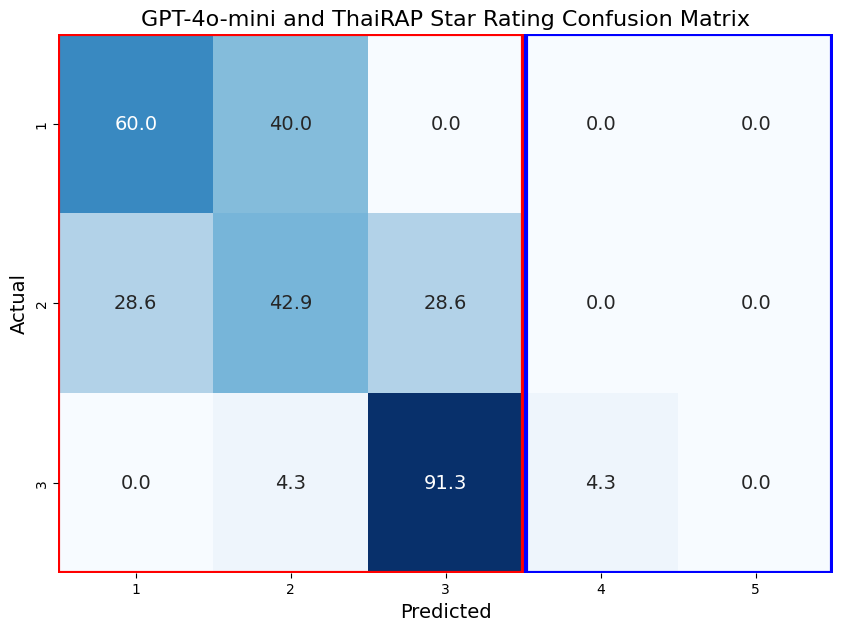

In [54]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load your dataset
df = pd.read_csv("./result/star_rating_confustion_matrix.csv")

# Generate the confusion matrix
conf_matrix = confusion_matrix(df['GT_Motorcyclist Star Rating Raw'], df['gpt_Motorcyclist Star Rating Raw'], labels=[1, 2, 3, 4, 5])

# Convert to a DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=[1, 2, 3, 4, 5], columns=[1, 2, 3, 4, 5])

# Calculate the row sums
row_sums = conf_matrix_df.sum(axis=1)

# Divide each value by the row sum and multiply by 100
conf_matrix_df_percent = conf_matrix_df.div(row_sums, axis=0) * 100

# Plot the confusion matrix with percentages, excluding rows 4 and 5
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df_percent.iloc[:3, :], annot=True, fmt='.1f', cmap='Blues', cbar=False, annot_kws={"fontsize": 14})

# Add red outline boxes to highlight cells (1,1) and (3,3)
ax = plt.gca()
ax.add_patch(patches.Rectangle((0, 0), 3, 3, edgecolor='red', facecolor='none', lw=3))
#ax.add_patch(patches.Rectangle((2, 2), 1, 1, edgecolor='red', facecolor='none', lw=3))
ax.add_patch(patches.Rectangle((3.02, 0), 1.97, 3, edgecolor='blue', facecolor='none', lw=3))

plt.title('GPT-4o-mini and ThaiRAP Star Rating Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

